In [1]:
import pytesseract as pt
import sys
import os
import cv2
import numpy as np
from Footage_Capture import get_workfolder
from matplotlib import pyplot as plt
import PIL

path = get_workfolder()
tempnum = 0

class Enhance_Image():

    def frame_to_grayscale(frame_path):
        grayscale_frame = cv2.imread(frame_path, cv2.IMREAD_GRAYSCALE)
        return grayscale_frame

    def crop_frame(frame, x0, y0, x1, y1):
        cropped_frame = frame[y0:y1, x0:x1]
        return cropped_frame

    def enhance_image(frame):
        enhanced = cv2.inRange(frame, 210, 255)
        global tempnum
        cv2.imwrite('./test%d.png' % tempnum, frame)
        tempnum += 1
        return enhanced


class Parse_Data():

    def __init__(self, folder_name, start_frame, finish_frame, fps=30):
        self.folder_name = folder_name
        self.start_frame = start_frame
        self.finish_frame = finish_frame
        self.fps = fps
        self.speed_list = []

    def get_path(self, frame_number):
        frame_path = path + self.folder_name + '//'[:-1] + \
            self.folder_name + 'frame_' + str(frame_number) + '.jpg'
        return frame_path

    def _get_speed(self, frame):
        text = pytesseract.image_to_string(frame)
        return text

    # def get_grayscales(self):
    #     grayscales = []
    #     for frame_number in range(self.start_frame, self.finish_frame):
    #         path = self.get_path(frame_number)
    #         grayscales.append(Enhance_Image.frame_to_grayscale(path))
    #     return grayscales

    # def get_cropped(self, grayscales, x0, y0, x1, y1):
    #     cropped = [Enhance_Image.crop_frame(
    #         frame, x0, y0, x1, y1) for frame in grayscales]
    #     return cropped

    def get_list_of_speeds(self):
        for x in range(self.start_frame, self.finish_frame):
            path = self.get_path(x)
            grayscale = Enhance_Image.frame_to_grayscale(path)
            cropped = Enhance_Image.crop_frame(grayscale, 130, 496, 283, 554)
            cropped = Enhance_Image.enhance_image(cropped)
            self.speed_list.append(self._get_speed(cropped))

    def output_to_file(self):
        log = open('./log.txt', 'w')
        if self.speed_list:
            for entry in self.speed_list:
                log.write(entry + '\n')
                
def temp_path(position, driver, gp, frame_num):
    temp = position + '_' + driver + '_' + gp
    path = const + temp + '//'[:-1] + temp + 'frame_' + str(frame_num) + '.jpg'
    return path


In [2]:
temp = 'P01_Leclerc_Russia'
Leclerc = Parse_Data(temp, 400, 500, fps=50)
const = r'/home/german/F1_tesseract/'
temp_arg = temp.split('_')
lec = temp_path(*temp_arg, 0)
input_frame = Enhance_Image.frame_to_grayscale(lec)

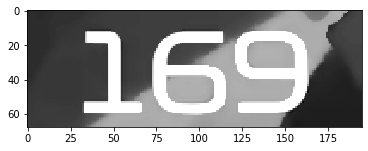

In [3]:
%matplotlib inline
cropped_frame = Enhance_Image.crop_frame(input_frame, 110, 490, 305, 558)
medblur = cv2.bilateralFilter(cropped_frame, 9, 20, 45)*1.4-30
plt.imshow(medblur, cmap = 'gray', vmin = 0, vmax = 255)
print(pt.image_to_string(medblur, lang='Formula1'))

In [76]:
speeds = []
for k in range(221,304):
    lec = temp_path(*temp_arg, k)
    input_frame = Enhance_Image.frame_to_grayscale(lec)
    cropped_frame = Enhance_Image.crop_frame(input_frame, 110, 465, 305, 558)
    bilateralFilter = cv2.bilateralFilter(cropped_frame, 9, 20, 5)
    #cv2.imwrite('eng.Formula1-Regular.exp'+str(k)+'.png', thresh)
    speeds.append(pt.image_to_string(bilateralFilter, lang='Formula1'))
ft = populate_array(speeds)

In [77]:
def populate_array(arr):
    """Convert the recognized values from str to int.
    If the value is not recognized properly, set the corresponding value to zero"""
    arr_2 = []
    for entry in arr:
        if entry.isdecimal():
            arr_2.append(entry)
        else:
            arr_2.append(0)
    return np.array(arr_2, dtype = np.uint16)

def get_distance(data, fps):
    """Get the distance of the lap based on average speeds multiplied by frame times,
    calculated as 1/fps"""
    dist = 1/fps
    avgs = []
    for i in range(1, len(data)):
        if avgs:
            avgs.append(dist*0.5*(data[i]+data[i-1])*1000/3600+avgs[i-2])
        else:
            avgs.append(dist*0.5*(data[i]+data[i-1])*1000/3600)
    return np.array(avgs, np.float16)

def avg_speeds(speeds):
    avgspeeds = [] 
    for i in range(len(speeds)-1):
        avgspeeds.append(0.5*(speeds[i+1]+speeds[i]))
    return np.array(avgspeeds, np.float16)

In [83]:
def plot(driver_name, gp, data):
    x = get_distance(ft, 50)
    y = interpolate_values(x,avg_speeds(ft))
    print(len(x))
    print(len(y))
    ax.set_xlabel(driver_name)
    ax.plot(x,y)
    fig.savefig(r'./kekekekekke.png')   

In [84]:
plot('Leclerc', 'Russia', ft)

82
82


In [79]:
def interpolate_values(dist, speeds):
    for i in range(1,len(speeds)-1):
        prev = speeds[i-1]
        curr = speeds[i]
        succ = speeds[i+1]
        if np.abs(curr-prev) and np.abs(succ-curr):
            speeds[i]=np.interp(dist[i], dist, speeds)
    return speeds

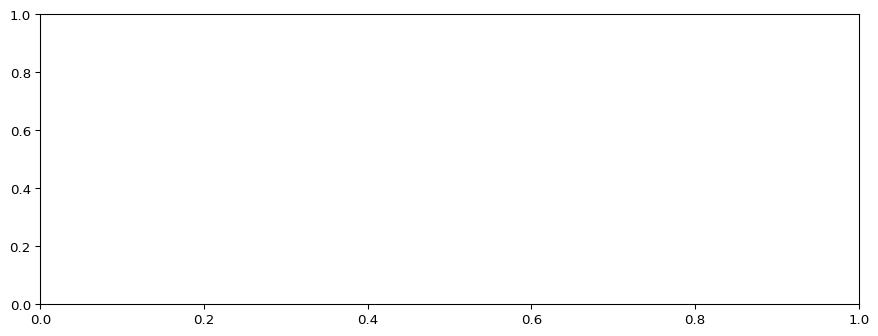

In [85]:
fig, ax = plt.subplots(1, 1, dpi = 96, figsize = (11, 4))